# Evaluating Gene Correlations - First heart field

In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt


from moscot.problems.time._lineage import TemporalProblem

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
Path="/home/mgander/Unrelated/moscotTime_Reproducibility/Data"
ts=['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25', 'E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5a', 'E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']

In [6]:
ct='E8.25:Neural crest'
i=11

ts0=ts[i]
ts1=ts[i+1]

In [7]:
gT=np.load(f"{Path}/TOME_transport_maps/{ts0}_{ct}_pull.npy", allow_pickle=True)
gM=np.load(f"{Path}/moscot_maps/{ts0}_{ct}_pull.npy", allow_pickle=True)

# Correlation for curated genes

The following list of genes was obtained by litarture seach when looking for genes that predict deveopment into first heart field cells. The key in the dictionary corresponds to the citation (Pubmed ID), and the values correspond to the genes the publication lists.

TOME used the following genes to identify the first heart field cluster: Tbx5, Hcn4, Gata4.

In [71]:
A=sc.read(f"{Path}/anndatas/Comb_anndatas/adata_{ts0}_{ts1}.h5ad")

Only considering the two last: ['.25', '.h5ad'].
Only considering the two last: ['.25', '.h5ad'].


In [8]:
adata=sc.read(f"{Path}/anndatas/scVI_anndatas/scvi_adata_{ts0}.h5ad")
adata.var.index=list(adata.var['gene_names'])

In [96]:
genes=list(A.var['gene_names'])

In [97]:
'Dlx2' in genes

True

In [54]:
sorted([a for a in genes if a[:2]=='Cd'])

['Cd200l1',
 'Cd24a',
 'Cd34',
 'Cd36',
 'Cd38',
 'Cd47',
 'Cd52',
 'Cd53',
 'Cd55',
 'Cd59a',
 'Cd63',
 'Cd7',
 'Cd70',
 'Cd74',
 'Cd81',
 'Cd82',
 'Cd8a',
 'Cd9',
 'Cd93',
 'Cd96',
 'Cdc20',
 'Cdc34',
 'Cdc42ep1',
 'Cdc42ep3',
 'Cdc42ep5',
 'Cdh1',
 'Cdh11',
 'Cdh17',
 'Cdh2',
 'Cdh20',
 'Cdh22',
 'Cdh5',
 'Cdhr2',
 'Cdk1',
 'Cdk2ap2',
 'Cdk5r2',
 'Cdkn1a',
 'Cdkn1c',
 'Cdkn2a',
 'Cdo1',
 'Cdx1',
 'Cdx2',
 'Cdx4']

In [86]:
D['PMID: 32908618']=['Sox10', 'Hoxb5',  'P75ntr', 'Ret', 'Ednrb']
D['PMID: 17065232']=['Sox10', 'Neurog1' ]
D['PMID: 22648184']=['Hoxb5', 'Ascl1', 'Caml1', 'Phox2b', 'Prok1', 'Prokr1']
D['PMID: 12640453']=['Edn3', 'Bdnf ']
D['PMID: 20478300']=['Sox9', 'Sox10', 'Pax3', 'Pax7', 'Tfap2a', 'Msx1', 'Msx2', 'Zic1', 'Ap2a2', 'Foxd3', 
                     'Snai2', 'Cdh7', 'Col2a1', 'Neurog1', 'Mitf', 'Dct']
D['PMID: 23246068']=['Dlx2']

In [ ]:
Sox10,Dlx2,Foxd3,Sox9


In [87]:
genes=[]
for a in D.values():
    genes=[*genes, *a]

# Eliminate duplicates
genes=[a for a in set(genes)]

In [88]:
hvgs=list(adata.var[adata.var['highly_variable']]['gene_names'])
genes_selected=[]
for gene in genes:
    if gene in hvgs:
        genes_selected.append(gene)

In [89]:
genes_selected

['Ednrb',
 'Col2a1',
 'Msx2',
 'Pax3',
 'Neurog1',
 'Sox9',
 'Foxd3',
 'Msx1',
 'Hoxb5',
 'Tfap2a',
 'Dnmt3b',
 'Snai2']

In [90]:
subset=True

DF=pd.DataFrame({})

for gene in genes_selected:
    loc=adata.var.index.get_loc(gene)
    exp=adata.layers['scvi_normalized'][:,loc]
    #exp=adataS.X[:,loc]
    #exp=np.array(exp.todense()).T[0]

    if subset==True:
        wh=np.where(adata.obs['cell_state'].isin(['E8:Rostral neuroectoderm']))[0]
        exp=exp[wh]
        gT2=gT[wh]
        gM2=gM[wh]
    else:
        gT2=gT.copy()
        gM2=gM.copy()


    (cor, p)=scipy.stats.spearmanr(exp, gT2)
    dfT=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'TOME', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
    (cor, p)=scipy.stats.spearmanr(exp, gM2)
    dfM=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'moscot', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
    DF=pd.concat([DF, dfM,dfT])
DF['Abs. Correlation']=abs(DF['Correlation'])
DF.index=np.arange(len(DF))

<Axes: xlabel='Abs. Correlation', ylabel='Timepoint'>

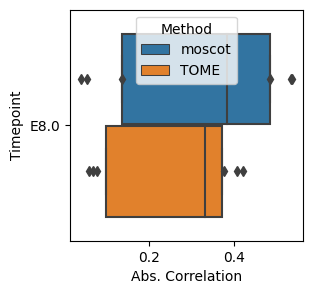

In [91]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
sns.boxplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)

<Axes: xlabel='Abs. Correlation', ylabel='Timepoint'>

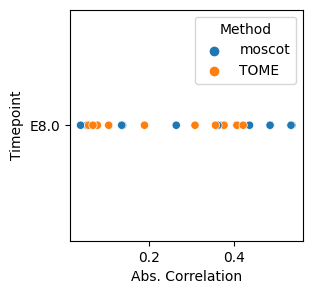

In [94]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
sns.scatterplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', ax=ax)

<Axes: xlabel='Abs. Correlation', ylabel='Timepoint'>

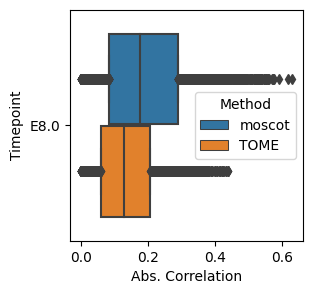

In [21]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
sns.boxplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)

In [22]:
DF

,Timepoint,Gene,Method,Correlation,P-value,type,Abs. Correlation
0,E8.0,Sox17,moscot,-0.035595,1.389025e-01,Spearman,0.035595
1,E8.0,Sox17,TOME,-0.007953,7.409930e-01,Spearman,0.007953
2,E8.0,Lypla1,moscot,0.143852,1.852680e-09,Spearman,0.143852
3,E8.0,Lypla1,TOME,0.165286,4.599193e-12,Spearman,0.165286
4,E8.0,Gm30414,moscot,-0.055898,2.006456e-02,Spearman,0.055898
...,...,...,...,...,...,...,...
5995,E8.0,mt-Co3,TOME,-0.098349,4.173905e-05,Spearman,0.098349
5996,E8.0,mt-Nd4,moscot,-0.163855,7.044555e-12,Spearman,0.163855
5997,E8.0,mt-Nd4,TOME,-0.178372,7.795694e-14,Spearman,0.178372
5998,E8.0,mt-Cytb,moscot,-0.124650,1.980735e-07,Spearman,0.124650


In [12]:
DF.sort_values('Abs. Correlation')

,Timepoint,Gene,Method,Correlation,P-value,type,Abs. Correlation
29,E8.0,Hand2,TOME,-0.003396,9.152152e-01,Spearman,0.003396
38,E8.0,Notch1,moscot,-0.069758,2.857989e-02,Spearman,0.069758
31,E8.0,Gata6,TOME,-0.070394,2.715789e-02,Spearman,0.070394
30,E8.0,Gata6,moscot,0.105395,9.236431e-04,Spearman,0.105395
39,E8.0,Notch1,TOME,0.145034,4.871496e-06,Spearman,0.145034
3,E8.0,Pdgfra,TOME,-0.160423,4.164936e-07,Spearman,0.160423
43,E8.0,Wnt1,TOME,0.210768,2.362115e-11,Spearman,0.210768
46,E8.0,Kdr,moscot,-0.223067,1.426996e-12,Spearman,0.223067
21,E8.0,Bmp4,TOME,0.260362,1.001031e-16,Spearman,0.260362
42,E8.0,Wnt1,moscot,0.268095,1.122996e-17,Spearman,0.268095


In [124]:
DF.to_pickle(f'{Path}/Correlations/{ts0}_FHF.npy')